# Modularity

In [1]:
import json
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dn_utils.misc import tidy_data
from dn_utils.path import path
from dn_utils.style import BLUE, ORANGE, BLUE_PALE, ORANGE_PALE
from scipy.stats import ttest_rel
from statsmodels.stats.anova import AnovaRM

%matplotlib inline

In [2]:
atlas = "combined_roi"
gamma_range = np.arange(0.5, 2.5, 0.5)

In [3]:
# Load graph measures
path_corrmats = join(path["bsc"], "corrmats")
path_corrmats_unthr = join(path_corrmats, atlas, "unthr")

q = {}
for gamma in gamma_range:
    gamma_str = str(float(gamma)).replace(".", "_")
    path_corrmats_unthr_gamma = join(path_corrmats_unthr, f"gamma_{gamma_str}")
    q[gamma] = np.load(join(path_corrmats_unthr_gamma, "q_aggregated.npy"))

# Load subject exclusion
df_exclusion = pd.read_csv(join(path["nistats"], "exclusion/exclusion.csv"), 
                           index_col=0)
ok_index = df_exclusion["ok_all"]

# Meta information about corrmats dimensions
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    corrmats_meta = json.loads(f.read()) 

In [4]:
# Additional arguments for tidy_data function
labels = [pd.Series(corrmats_meta["dim1"])[ok_index].to_list(),
          corrmats_meta["dim2"],
          corrmats_meta["dim3"]]
palette = {"perr_pos": ORANGE, "perr_neg": BLUE}
palette_con = {"rew": ORANGE_PALE, "pun": BLUE_PALE}

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            1.0178 1.0000 28.0000 0.3217
perr_sign      2.0110 1.0000 28.0000 0.1672
con:perr_sign  0.7098 1.0000 28.0000 0.4067

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.0071 1.0000 28.0000 0.9337
perr_sign      0.7922 1.0000 28.0000 0.3810
con:perr_sign  0.1865 1.0000 28.0000 0.6691

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.0817 1.0000 28.0000 0.7771
perr_sign      0.6898 1.0000 28.0000 0.4133
con:perr_sign  0.0488 1.0000 28.0000 0.8267

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.3416 1.0000 28.0000 0.5636
perr_sign      0.0075 1.0000 28.0000 0.9314
con:perr_sign  0.0000 1.0000 28.0000 0.9964



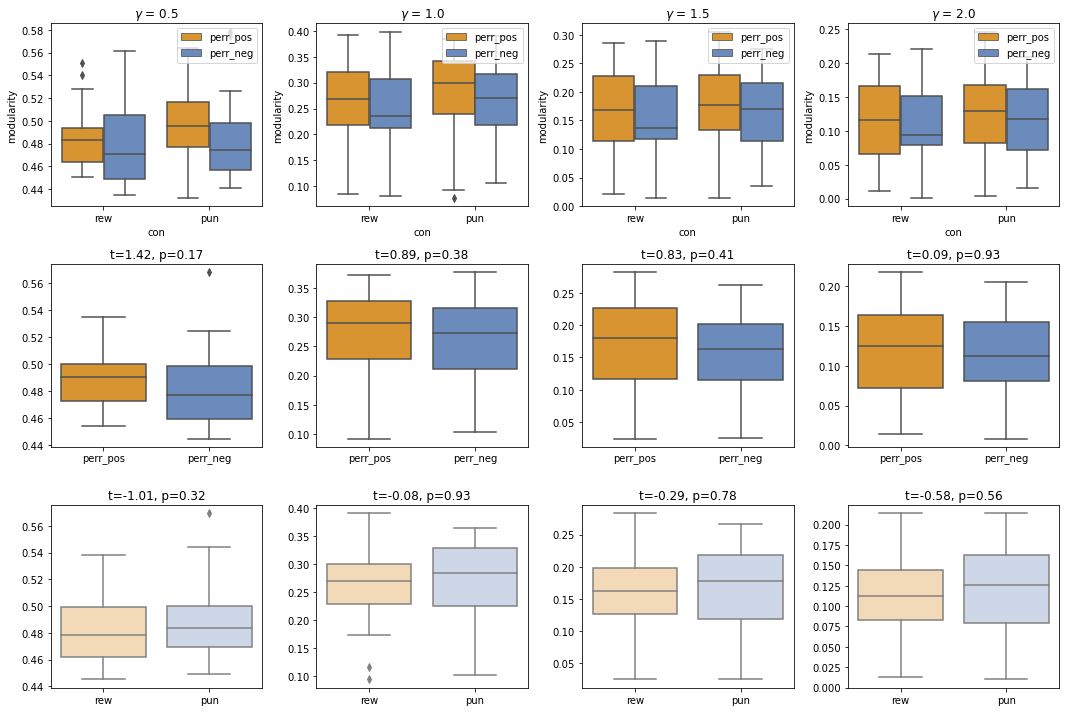

In [5]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))


for i, gamma in enumerate(gamma_range):
    
    depvar = "modularity"
    data = tidy_data(
        q[gamma][ok_index],
        depvar=depvar,
        columns=["sub", "con", "perr_sign"],
        labels=labels,
    )
    anova = AnovaRM(
        data=data, 
        depvar=depvar, 
        subject="sub", 
        within=["con", "perr_sign"]
    )
    results = anova.fit()
    print(results)

    sns.boxplot(
        x="con", 
        y=depvar, 
        hue="perr_sign", 
        data=data, 
        ax=axs[0][i], 
        palette=palette
    )
    axs[0][i].set_title(f"$\gamma$ = {gamma}")
    axs[0][i].legend(loc=1)
    
    # Second row (prediction error effect)
    q_perr = np.mean(q[gamma][ok_index], axis=1)
    stats_perr = ttest_rel(q_perr[:, 0], q_perr[:, 1])
    
    sns.boxplot(
        data=pd.DataFrame(q_perr, columns=["perr_pos", "perr_neg"]),
        palette=palette,
        ax=axs[1][i]
    )        
    axs[1][i].set_title(
        f"t={stats_perr.statistic:.2f}, p={stats_perr.pvalue:.2f}",
        fontWeight=400 if stats_perr.pvalue > 0.1 else 800
    )
    if stats_perr.pvalue < 0.05:
        axs[1][i].set_facecolor('#bbb')
    elif stats_perr.pvalue < 0.1:
        axs[1][i].set_facecolor('#eee')
    
    # Third row (condition effect)
    q_con = np.mean(q[gamma][ok_index], axis=2)
    stats_con = ttest_rel(q_con[:, 0], q_con[:, 1])

    sns.boxplot(
        data=pd.DataFrame(q_con, columns=["rew", "pun"]),
        palette=palette_con,
        ax=axs[2][i]
    )        
    axs[2][i].set_title(
        f"t={stats_con.statistic:.2f}, p={stats_con.pvalue:.2f}",
        fontWeight=400 if stats_con.pvalue > 0.1 else 600
    )
    if stats_con.pvalue < 0.05:
        axs[2][i].set_facecolor('#bbb')
    elif stats_con.pvalue < 0.1:
        axs[2][i].set_facecolor('#eee')

    
plt.tight_layout()